# This file is an attempted replication of the work in "Identification  of Nonlinear  Dynamic  Systems  Using  Neural  Networks", by Masri et al. in 1993. 
The code below will strongly resemble the code in Fma_framed. I should implement a class next time.

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.signal import chirp
import tensorflow as tf
import matplotlib.pyplot as plt
from functools import partial # Import this due to weird lambda behavior
%load_ext tensorboard

## Training data generation methods

In [23]:
# Generate the u(t) inputs to the dynamics
# def input_generator(t, mean=0, variance=1):
#     # Arguments:
#     # t: A scalar time step - useless
#     # mean: Mean of generated random Gaussian input
#     # variance: Variance of generated input
#     return np.random.normal(mean, variance)

# Function that outputs dynamics dx/dt when given current states, i.e. state dynamics
def Duffing(x, t, u=lambda x : 0):
    # Arguments: x = [velocity, position]^T, t = current time.
    # Output: dx/dt= [acceleration, velocity]^T
    # Assumes scalar position
    # The Duffing oscillator dynamics in this code / the source paper: 
    # y'' = u - 1.25y' - 2pi*y - 10y^3
    return np.array([u(t) - 1.25*x[0] - 2*np.pi*x[1] - 10*x[1]*x[1]*x[1], x[0]])

# Synthesizes system trajectory by feeding input u(t) into specified dynamics function y().
# Uses odeint solver.
def data_generator(t_interval=[0,1], dt=0.01, init=None, u=lambda x : 0):
    # Arguments: [start time, end time], time interval, initial conditions, input function
    t = np.arange(t_interval[0], t_interval[1], dt)
    if init is None:
        init = np.array([0, 0])
    x = odeint(func=Duffing, y0=init, t=t, args=(u,)) # (u,) creates an one-element tuple
    # Returns an array where first row is time, and 2nd~last rows are states
    return np.vstack((t, x.T))

# Segments input data into numerous training timeframes
def framing(input_data, output_data, data_ind, frame_size, pred_size=1):
    # Arguments:
    # input_data: The training input data that is to be made into overlapping frames. Should be 2D.
    # output_data: The labels of corresponding input data. Will be made into matching frames.
    # data_ind: The indices where data from a new segment starts.
    # Outputs:
    # input_frames: An array of frames, in the shape of (Nframes, <2D frame shape>)
    # output_frames: An array of outputs corresponding to each frame in input_frames
    # pred_frames: An array of future frames corresponding to each frame in input_frames
    # frames_ind: A list detailing the index where a frame from a different segment starts.
    
    Ninputrow = input_data[0].shape[0]
    Noutputrow = output_data[0].shape[0]
    print(Noutputrow)
    # Generate data by splitting it into successive overlapping frames.
    # Its first dimension is going to be samples. Each 2D sample occupies the 2nd and 3rd.
    # Empty lists to hold the results:
    input_frames = []
    output_frames = []
    pred_frames = []
    frames_ind = [0]
    # Process each segment
    for i in range(len(data_ind)-1):
        Nframes = data_ind[i+1]-data_ind[i] - pred_size - frame_size
        inframes = np.zeros((Nframes, Ninputrow, frame_size))
        outframes = np.zeros((Nframes, Noutputrow, 1)) # Assuming scalar output
#         outdata = np.reshape(output_data[i], (-1,output_data[i].shape[-1])) # Force into 2D
#         outframes = np.zeros((Nframes, outdata[i].shape[0], 1)) # Assuming scalar output
        predframes = np.zeros((Nframes, Ninputrow, pred_size))
        
        # Put into frames
        for j in range(Nframes):
            inframes[j,:,:] = input_data[i][:,j:j+frame_size]
            outframes[j,:,:] = output_data[i][:,j+frame_size-1] # Output at the final timestep
        
        # Also offer complementary future state if you're into predictions
        if pred_size > 0:
            for j in range(Nframes):
                predframes[j,:,:] = input_data[i][:, j+frame_size:j+frame_size+pred_size]
        
        input_frames.append(inframes)
        output_frames.append(outframes)
        pred_frames.append(predframes)
        frames_ind.append(Nframes)
    
    # Combine everything into arrays
    input_frames = np.concatenate(input_frames)
    output_frames = np.concatenate(output_frames)
    pred_frames = np.concatenate(pred_frames)
    frames_ind = np.cumsum(frames_ind)
    
    return input_frames, output_frames, pred_frames, frames_ind

# Systematically generate segments of data.
# This part used to be a function, but I decided that it's not worth it. 
Nd_seg = 2000
Nseg = 1
dt = 0.01 # The paper didn't specify this value, though?
t_list = [0,Nd_seg*dt]
# The paper used a chirp; scale it down by its magnitude (4pi^2, around 40)
u_func_list = [partial(chirp, f0=0.9, f1=1.1, t1=1)]
noise_level = 0 # 0.1

# Use some random input as test data excitation:
u_params = np.random.uniform(0, 2, (1, Nseg))
ts_steps = np.arange(t_list[0], t_list[1], dt)
u_func_list += [
    interp1d( ts_steps, np.random.normal(0, 2, ts_steps.shape), fill_value="extrapolate", kind='cubic'),
    interp1d( ts_steps, np.random.normal(0, 2, ts_steps.shape), fill_value="extrapolate", kind='cubic'),
    interp1d( ts_steps, np.random.normal(0, 2, ts_steps.shape), fill_value="extrapolate", kind='cubic')
]

Nseg = len(u_func_list)
t_list = np.array([[0,Nd_seg*dt]] * Nseg).T

# Trajectory storage variables
data_list = []
input_list = []
output_list = []

# Initial conditions of each segment
init_conds = np.zeros((2, Nseg))

# Generate data for each segment
for i in range(Nseg):
    data_list.append( data_generator(t_list[:,i], dt, init_conds[:,i], u_func_list[i]) )
    # Regenerate input time history
    input_list.append( [u_func_list[i](t) for t in data_list[i][0,:]] )
    # Regenerate the oscillator output g in the paper
    output_list.append( np.array([1.25*x[1] + 2*np.pi*x[2] + 10*x[2]*x[2]*x[2] for x in np.swapaxes(data_list[i],0,1)]) )
# Put together as one matrix with time-input data, and one with output data.
# Don't concatenate them into one full array yet - let the framing function do this.
# The replication doesn't use time input.
# The input consists of [velocity, position]. Still kept the input in the last row for good measure.
# The first one in the list is the training data; the rest are test data.
InputDataset = [ np.vstack((data_list[i], input_list[i])) for i in range(Nseg) ]
OutputDataset = [ output_list[i].reshape(1,-1) for i in range(Nseg) ] # -1 stands for the dim size to be inferred

# Index list for train and test data
seg_ind_list = [0, data_list[0].shape[1]]
seg_ind_list_test = [0] + [data_list[i+1].shape[1] for i in range(Nseg-1)]
seg_ind_list_test = np.cumsum(seg_ind_list_test)

# Add noise to observation. This replication doesn't need noise.
# for i in range(Nseg):
#     output_data[i] += output_data[i] * noise_level * np.random.randn(1, output_data[i].shape[-1])

Inputset = [InputDataset[0]]
Outputset = [OutputDataset[0]]
input_test = InputDataset[1:]
answer_test = OutputDataset[1:]

In [37]:
Outputset[0].reshape(1,-1).shape
Inputset = [InputDataset[0]]
np.squeeze(OutputFset,2).shape

## Plot the generated data for visual inspection

Text(0.5, 0.98, 'Training data')

<Figure size 432x288 with 0 Axes>

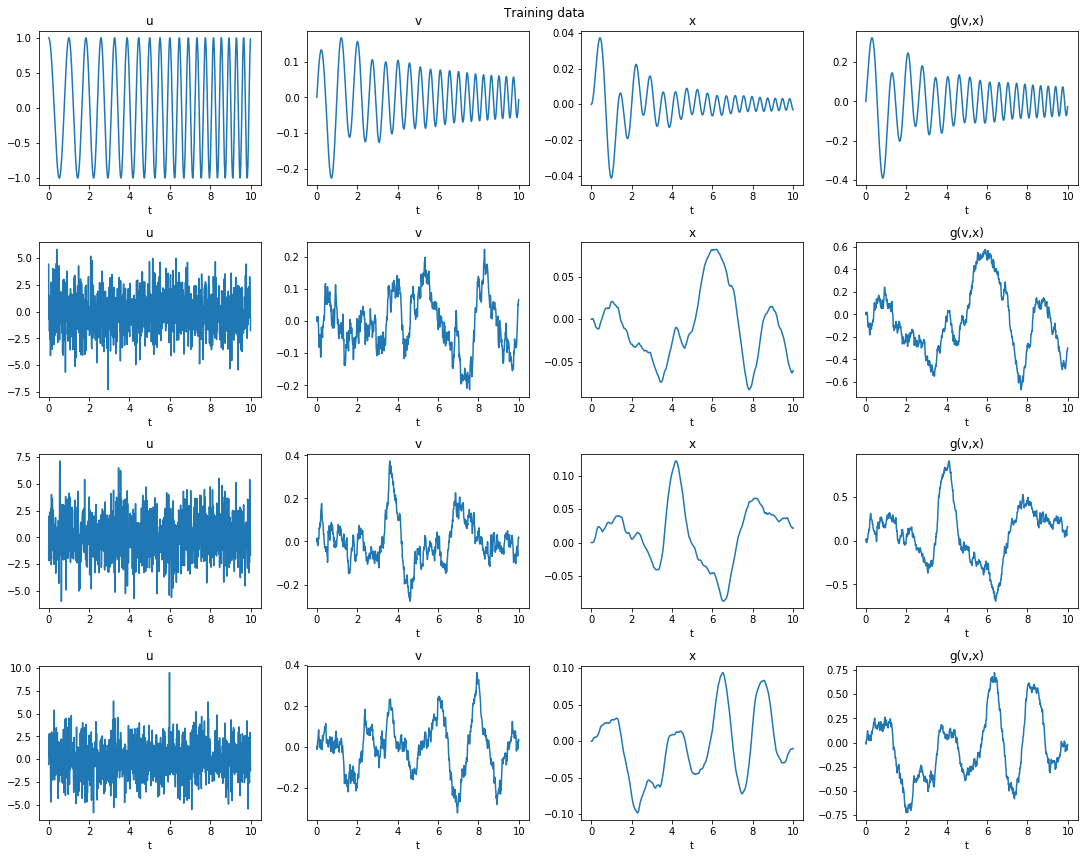

In [21]:
plt.clf()
fig,axs = plt.subplots(Nseg, 4, constrained_layout=True, figsize = (15,12))

# Generate correct answer for each test, as well as run input through prediction
plot_skip_rate = 1 # Only plot a point for every this number of samples
for i in range(Nseg):
    # Plot both cases
    axs[i][0].plot(InputDataset[i][0,::plot_skip_rate], InputDataset[i][3,::plot_skip_rate])
    axs[i][0].set_title('u')
    axs[i][0].set_xlabel('t')
    axs[i][1].plot(InputDataset[i][0,::plot_skip_rate], InputDataset[i][1,::plot_skip_rate])
    axs[i][1].set_title('v')
    axs[i][1].set_xlabel('t')
    axs[i][2].plot(InputDataset[i][0,::plot_skip_rate], InputDataset[i][2,::plot_skip_rate])
    axs[i][2].set_title('x')
    axs[i][2].set_xlabel('t')
    axs[i][3].plot(InputDataset[i][0,::plot_skip_rate], OutputDataset[i][0,::plot_skip_rate])
    axs[i][3].set_title('g(v,x)')
    axs[i][3].set_xlabel('t')
fig.suptitle('Training data')

## Neural Nets section

In [22]:
# Set seed to ensure reprodicibility
tf.random.set_seed(2020)

# Set log directory for tensorboard visualization later
log_dir = "Duffing_logs/fit/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

def train_prep(seed=2020):
    # Clear previous model
    tf.keras.backend.clear_session()
    # Clear any Tensorboard logs from previous runs
    !rm -rf ./Duffing_logs/ 
    tf.random.set_seed(seed)


In [55]:
train_prep()

# Neural net construction
frame_size = 1
Activation = tf.keras.activations.tanh
Regularizer = tf.keras.regularizers.l1(0.001)

model = tf.keras.models.Sequential([
#     tf.keras.layers.Flatten(),
    tf.keras.layers.Reshape((2,), input_shape=(2,1)), # Found the solution to weird shape requirements in Tensorflow
    tf.keras.layers.Dense(15, activation = Activation, kernel_regularizer = Regularizer, 
                          input_shape = (2,)), #(InputFset.shape[1],InputFset.shape[2])), # This shape doesn't seem to matter
    tf.keras.layers.Dense(10, activation = Activation, kernel_regularizer = Regularizer), 
    tf.keras.layers.Dense(1, activation = Activation)  # Output. They also used activation on output.
])
Nlayer = 2
Epoch = 80

# Learning rate: Default is 0.001
# Loss function: Use the simplest squared error for now.
model.compile(optimizer = 'adam', loss = tf.keras.losses.mean_squared_error)

In [56]:
# Train the model.
# First, generate framed data if needed.
(InputFset, OutputFset, PredictFset, train_ind_list) = framing(Inputset, Outputset, seg_ind_list, frame_size=frame_size, pred_size=0)
# Next, train.
# Training method 1: Do it altogether
history = model.fit(InputFset[:,1:3,:], OutputFset, epochs=Epoch, callbacks=[tensorboard_callback])
# history = model.fit(np.squeeze(InputFset[:,1:3,:],2), np.squeeze(OutputFset,2), epochs=Epoch, callbacks=[tensorboard_callback])
model.summary()
# Training method 2: Train it batch by batch

1
Train on 1999 samples
Epoch 1/80
1999/1999 [==============================] - 1s 475us/sample - loss: 0.0509
Epoch 2/80
1999/1999 [==============================] - 0s 57us/sample - loss: 0.0407
Epoch 3/80
1999/1999 [==============================] - 0s 60us/sample - loss: 0.0325
Epoch 4/80
1999/1999 [==============================] - 0s 56us/sample - loss: 0.0255
Epoch 5/80
1999/1999 [==============================] - 0s 52us/sample - loss: 0.0196
Epoch 6/80
1999/1999 [==============================] - 0s 50us/sample - loss: 0.0149
Epoch 7/80
1999/1999 [==============================] - 0s 38us/sample - loss: 0.0113
Epoch 8/80
1999/1999 [==============================] - 0s 46us/sample - loss: 0.0087
Epoch 9/80
1999/1999 [==============================] - 0s 49us/sample - loss: 0.0070
Epoch 10/80
1999/1999 [==============================] - 0s 48us/sample - loss: 0.0062
Epoch 11/80
1999/1999 [==============================] - 0s 43us/sample - loss: 0.0058
Epoch 12/80
1999/1999 [====

In [57]:
model.get_layer('dense_2').output

<tf.Tensor 'dense_2/Identity:0' shape=(None, 1) dtype=float32>

In [58]:
# Backup the model (optional).
# Save the entire model as a SavedModel.
!mkdir -p models/Duffing_models
model.save('models/Duffing_models/{0}-{1}-{2}-{3}'.format(Nlayer, Nneuron, frame_size, Epoch)) 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/Duffing_models/80-original/assets


## Validation and testing

In [73]:
# Process test data to keep in the same form of training data
(input_f_test, answer_f_test, pred_f_test, test_ind_list) = framing(
    input_test, answer_test, seg_ind_list_test, frame_size=frame_size, pred_size=0
)

1


Text(0.5, 0.98, 'Performance of original model')

<Figure size 432x288 with 0 Axes>

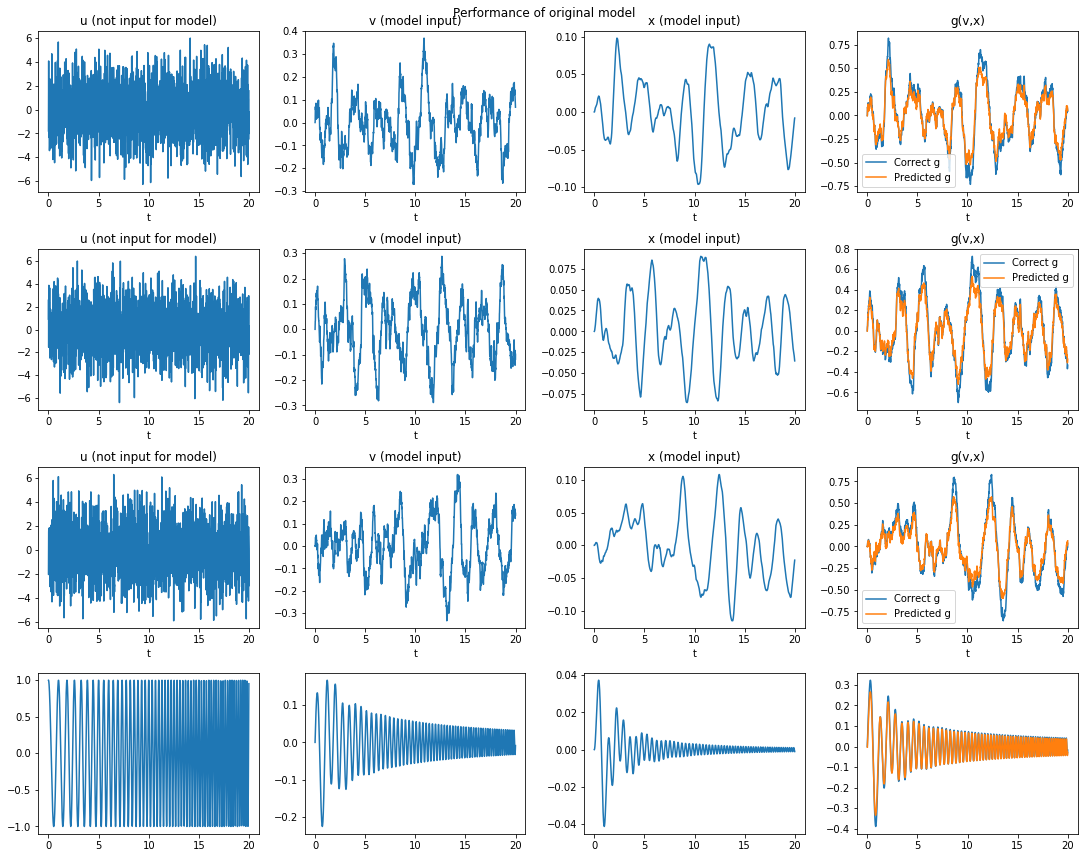

In [100]:
# Plot prediction 
plt.clf()
fig,axs = plt.subplots(Nseg, 4, constrained_layout=True, figsize = (15,12))

plot_skip_rate = 1 # Only plot a point for every this number of samples
for i in range(len(test_ind_list)-1):
    i0 = test_ind_list[i]
    i1 = test_ind_list[i+1]
    j0 = seg_ind_list_test[i]
    j1 = seg_ind_list_test[i+1]
    # Generate prediction
    result = model.predict(input_f_test[i0:i1,1:3,:])
    # Plot both correct answer and prediction
    axs[i][0].plot(input_test[i][0,::plot_skip_rate], input_test[i][3,::plot_skip_rate])
    axs[i][0].set_title('u (not input for model)')
    axs[i][0].set_xlabel('t')
    axs[i][1].plot(input_test[i][0,::plot_skip_rate], input_test[i][1,::plot_skip_rate])
    axs[i][1].set_title('v (model input)')
    axs[i][1].set_xlabel('t')
    axs[i][2].plot(input_test[i][0,::plot_skip_rate], input_test[i][2,::plot_skip_rate])
    axs[i][2].set_title('x (model input)')
    axs[i][2].set_xlabel('t')
    axs[i][3].plot(input_test[i][0,frame_size:], np.squeeze(answer_f_test[i0:i1]))
    axs[i][3].plot(input_test[i][0,frame_size:], np.squeeze(result))
    axs[i][3].set_title('g(v,x)')
    axs[i][3].set_xlabel('t')
    axs[i][3].legend(['Correct g','Predicted g'])
# fig.suptitle('Model trained with %d layers, each with %d neurons, taking %d recent samples' % (Nlayer, Nneuron, frame_size))
# Also show the performance on training data
axs[-1][0].plot(Inputset[0][0,::plot_skip_rate], Inputset[0][3,::plot_skip_rate])
axs[-1][1].plot(Inputset[0][0,::plot_skip_rate], Inputset[0][1,::plot_skip_rate])
axs[-1][2].plot(Inputset[0][0,::plot_skip_rate], Inputset[0][2,::plot_skip_rate])
axs[-1][3].plot(Inputset[0][0,:], Outputset[0][0])
axs[-1][3].plot(Inputset[0][0,frame_size:], model.predict(InputFset[:,1:3,:]))
fig.suptitle('Performance of original model')

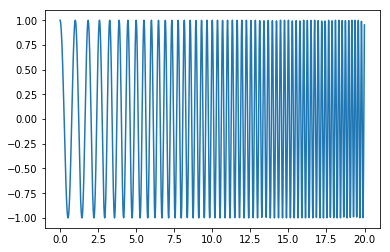

In [85]:
ttests = np.arange(0,20,0.01)
us = u_func_list[0](ttests)
plt.plot(ttests, us)

## Inspect net

In [180]:
%tensorboard --logdir Duffing_logs/fit #--host localhost

In [ ]:
# Inspect weights
print(model.get_layer('dense').weights) # Input layer
print(model.get_layer('dense_1').weights)
print(model.get_layer('dense_2').weights)
# print(model.get_layer('dense_3').weights)
# print(model.get_layer('dense_4').weights) # Output layer
model.summary()

In [ ]:
# Inspect layer outputs
model.get_layer('dense_1').output
# Ref: https://stackoverflow.com/a/48966702 & https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer
earlyPred = tf.keras.Model(model.input, model.get_layer('dense_4').output)

## Tests to learn more about the model

1. What if inputs don't follow the state dynamics. Would it still work?

In [113]:
# 1. What if inputs don't follow the state dynamics. Would it still work?
ttest = np.arange(0, 10, 0.01)
vtest = ttest * ttest / 100 # t^2/100
xtest = (ttest - 5) / 50     # t/5-1
gtest = 1.25*vtest + 2*np.pi*xtest + 10*xtest*xtest*xtest # 1.25v + 2pi*x + 10x^3
pred_test = model.predict(np.vstack((vtest, xtest)).T[:,:,None])

Text(0.5, 0.98, 'Performance on nonsensical input (linear - quadratic)')

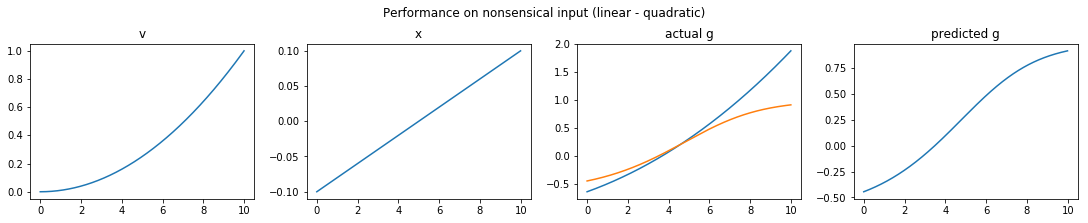

In [116]:
figt,axst = plt.subplots(1, 4, constrained_layout=True, figsize = (15,3))

axst[0].plot(ttest, vtest)
axst[0].set_title('v')
axst[1].plot(ttest, xtest)
axst[1].set_title('x')
axst[2].plot(ttest, gtest)
axst[2].set_title('actual g')
axst[3].plot(ttest, pred_test)
axst[3].set_title('predicted g')
figt.suptitle('Performance on nonsensical input (linear - quadratic)')

Text(0.5, 0.98, 'Performance on nonsensical input (sinusoid)')

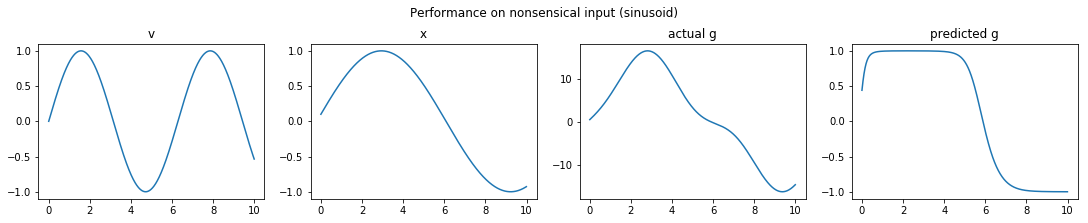

In [109]:
ttest = np.arange(0, 10, 0.01)
vtest = np.sin(ttest) # sin(t)
xtest = np.sin(ttest/2+0.1)     # sin(0.5t+0.1)
gtest = 1.25*vtest + 2*np.pi*xtest + 10*xtest*xtest*xtest # 1.25v + 2pi*x + 10x^3
pred_test = model.predict(np.vstack((vtest, xtest)).T[:,:,None])

figt,axst = plt.subplots(1, 4, constrained_layout=True, figsize = (15,3))
axst[0].plot(ttest, vtest)
axst[0].set_title('v')
axst[1].plot(ttest, xtest)
axst[1].set_title('x')
axst[2].plot(ttest, gtest)
axst[2].set_title('actual g')
axst[3].plot(ttest, pred_test)
axst[3].set_title('predicted g')
figt.suptitle('Performance on nonsensical input (sinusoid)')

Text(0.5, 0.98, 'Performance on sensical input (sinusoid)')

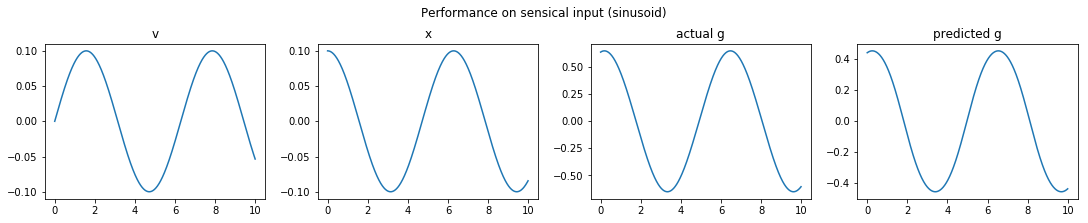

In [111]:
ttest = np.arange(0, 10, 0.01)
vtest = np.sin(ttest)*0.1 # sin(t)
xtest = np.cos(ttest)*0.1 # cos(t)
gtest = 1.25*vtest + 2*np.pi*xtest + 10*xtest*xtest*xtest # 1.25v + 2pi*x + 10x^3
pred_test = model.predict(np.vstack((vtest, xtest)).T[:,:,None])

figt,axst = plt.subplots(1, 4, constrained_layout=True, figsize = (15,3))
axst[0].plot(ttest, vtest)
axst[0].set_title('v')
axst[1].plot(ttest, xtest)
axst[1].set_title('x')
axst[2].plot(ttest, gtest)
axst[2].set_title('actual g')
axst[3].plot(ttest, pred_test)
axst[3].set_title('predicted g')
figt.suptitle('Performance on sensical input (sinusoid)')

Text(0.5, 0.98, 'Performance on unseen sensical input (sinusoid)')

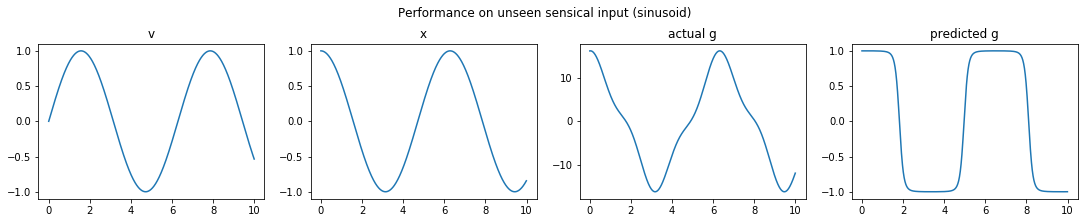

In [112]:
ttest = np.arange(0, 10, 0.01)
vtest = np.sin(ttest) # sin(t)
xtest = np.cos(ttest) # cos(t)
gtest = 1.25*vtest + 2*np.pi*xtest + 10*xtest*xtest*xtest # 1.25v + 2pi*x + 10x^3
pred_test = model.predict(np.vstack((vtest, xtest)).T[:,:,None])

figt,axst = plt.subplots(1, 4, constrained_layout=True, figsize = (15,3))
axst[0].plot(ttest, vtest)
axst[0].set_title('v')
axst[1].plot(ttest, xtest)
axst[1].set_title('x')
axst[2].plot(ttest, gtest)
axst[2].set_title('actual g')
axst[3].plot(ttest, pred_test)
axst[3].set_title('predicted g')
figt.suptitle('Performance on unseen sensical input (sinusoid)')

Text(0.5, 0.98, 'Performance on sensical input (linear - quadratic)')

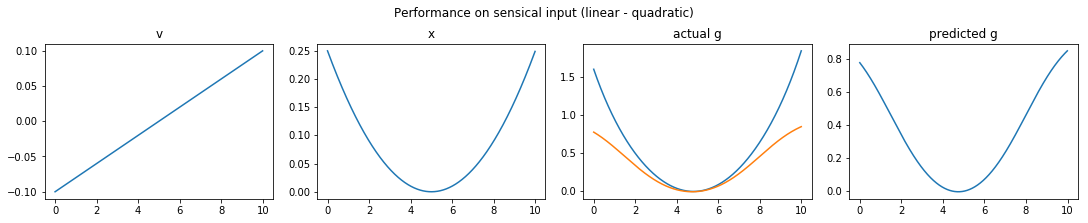

In [120]:
ttest = np.arange(0, 10, 0.01)
xtest = (ttest - 5) * (ttest - 5) / 100 # (t-5)^2/100
vtest = (ttest - 5) / 50                # (t-5)/50
gtest = 1.25*vtest + 2*np.pi*xtest + 10*xtest*xtest*xtest # 1.25v + 2pi*x + 10x^3
pred_test = model.predict(np.vstack((vtest, xtest)).T[:,:,None])

figt,axst = plt.subplots(1, 4, constrained_layout=True, figsize = (15,3))
axst[0].plot(ttest, vtest)
axst[0].set_title('v')
axst[1].plot(ttest, xtest)
axst[1].set_title('x')
axst[2].plot(ttest, gtest)
axst[2].plot(ttest, pred_test)
axst[2].set_title('actual g')
axst[3].plot(ttest, pred_test)
axst[3].set_title('predicted g')
figt.suptitle('Performance on sensical input (linear - quadratic)')

2. What if the model is larger? Or smaller? Would 4-4-1 work? 

In [141]:
# 2.
# Neural net construction
frame_size = 1
Activation = tf.keras.activations.tanh
Regularizer = tf.keras.regularizers.l1(0.001)
Nlayer = 2
Nneuron = 5
model_alt = tf.keras.models.Sequential([
#     tf.keras.layers.Flatten(),
    tf.keras.layers.Reshape((2,), input_shape=(2,1)), # Found the solution to weird shape requirements in Tensorflow
    tf.keras.layers.Dense(Nneuron, activation = Activation, kernel_regularizer = Regularizer, 
                          input_shape = (2,)), #(InputFset.shape[1],InputFset.shape[2])), # This shape doesn't seem to matter
    tf.keras.layers.Dense(Nneuron, activation = Activation, kernel_regularizer = Regularizer), 
    tf.keras.layers.Dense(1, activation = Activation)  # Output. They also used activation on output.
])
Epoch = 80

# Learning rate: Default is 0.001
# Loss function: Use the simplest squared error for now.
model_alt.compile(optimizer = 'adam', loss = tf.keras.losses.mean_squared_error)

# Generate training data and train
# (InputFset, OutputFset, PredictFset, train_ind_list) = framing(Inputset, Outputset, seg_ind_list, frame_size=frame_size, pred_size=0)

history = model_alt.fit(InputFset[:,1:3,:], OutputFset, epochs=Epoch, callbacks=[tensorboard_callback])
model_alt.summary()

Train on 1999 samples
Epoch 1/80
1999/1999 [==============================] - 0s 241us/sample - loss: 0.0212
Epoch 2/80
1999/1999 [==============================] - 0s 63us/sample - loss: 0.0175
Epoch 3/80
1999/1999 [==============================] - 0s 43us/sample - loss: 0.0152
Epoch 4/80
1999/1999 [==============================] - 0s 65us/sample - loss: 0.0135
Epoch 5/80
1999/1999 [==============================] - 0s 40us/sample - loss: 0.0121
Epoch 6/80
1999/1999 [==============================] - 0s 40us/sample - loss: 0.0108
Epoch 7/80
1999/1999 [==============================] - 0s 50us/sample - loss: 0.0095
Epoch 8/80
1999/1999 [==============================] - 0s 43us/sample - loss: 0.0084
Epoch 9/80
1999/1999 [==============================] - 0s 53us/sample - loss: 0.0076
Epoch 10/80
1999/1999 [==============================] - 0s 48us/sample - loss: 0.0070
Epoch 11/80
1999/1999 [==============================] - 0s 48us/sample - loss: 0.0066
Epoch 12/80
1999/1999 [======

Text(0.5, 0.98, 'Performance of original model')

<Figure size 432x288 with 0 Axes>

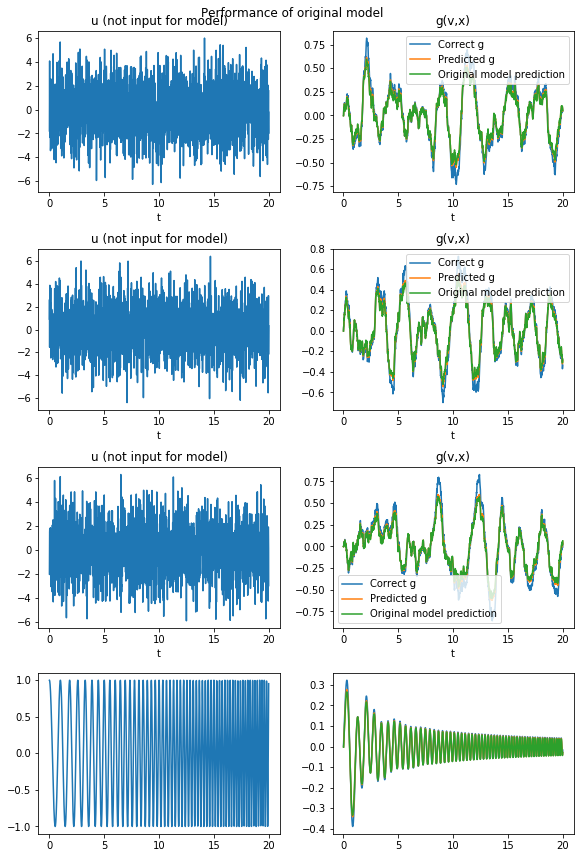

In [145]:
# Plot prediction 
plt.clf()
fig,axs = plt.subplots(Nseg, 2, constrained_layout=True, figsize = (8,12))

plot_skip_rate = 1 # Only plot a point for every this number of samples
for i in range(len(test_ind_list)-1):
    i0 = test_ind_list[i]
    i1 = test_ind_list[i+1]
    # Generate prediction
    result_alt = model_alt.predict(input_f_test[i0:i1,1:3,:])
    # Plot both correct answer and prediction
    axs[i][0].plot(input_test[i][0,::plot_skip_rate], input_test[i][3,::plot_skip_rate])
    axs[i][0].set_title('u (not input for model)')
    axs[i][0].set_xlabel('t')
#     axs[i][1].plot(input_test[i][0,::plot_skip_rate], input_test[i][1,::plot_skip_rate])
#     axs[i][1].set_title('v (model input)')
#     axs[i][1].set_xlabel('t')
#     axs[i][2].plot(input_test[i][0,::plot_skip_rate], input_test[i][2,::plot_skip_rate])
#     axs[i][2].set_title('x (model input)')
#     axs[i][2].set_xlabel('t')
    axs[i][1].plot(input_test[i][0,frame_size:], np.squeeze(answer_f_test[i0:i1]))
    axs[i][1].plot(input_test[i][0,frame_size:], np.squeeze(result_alt))
    axs[i][1].plot(input_test[i][0,frame_size:], np.squeeze(model.predict(input_f_test[i0:i1,1:3,:])))
    axs[i][1].set_title('g(v,x)')
    axs[i][1].set_xlabel('t')
    axs[i][1].legend(['Correct g','Predicted g','Original model prediction'])
# fig.suptitle('Model trained with %d layers, each with %d neurons, taking %d recent samples' % (Nlayer, Nneuron, frame_size))
# Also show the performance on training data
axs[-1][0].plot(Inputset[0][0,::plot_skip_rate], Inputset[0][3,::plot_skip_rate])
# axs[-1][1].plot(Inputset[0][0,::plot_skip_rate], Inputset[0][1,::plot_skip_rate])
# axs[-1][2].plot(Inputset[0][0,::plot_skip_rate], Inputset[0][2,::plot_skip_rate])
axs[-1][1].plot(Inputset[0][0,:], Outputset[0][0])
axs[-1][1].plot(Inputset[0][0,frame_size:], model_alt.predict(InputFset[:,1:3,:]))
axs[-1][1].plot(Inputset[0][0,frame_size:], model.predict(InputFset[:,1:3,:]))
fig.suptitle('Performance of original model')


Text(0.5, 0.98, 'Performance on sensical input (linear - quadratic)')

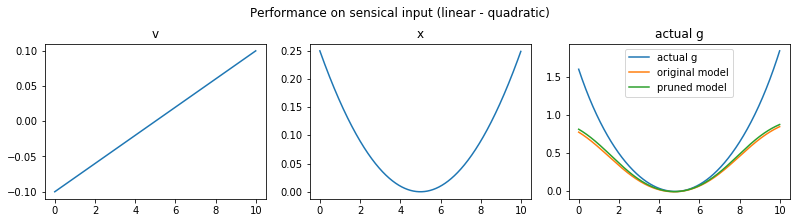

In [146]:
# We can also check their performance regarding unseen inputs.
ttest = np.arange(0, 10, 0.01)
xtest = (ttest - 5) * (ttest - 5) / 100 # (t-5)^2/100
vtest = (ttest - 5) / 50                # (t-5)/50
gtest = 1.25*vtest + 2*np.pi*xtest + 10*xtest*xtest*xtest # 1.25v + 2pi*x + 10x^3
pred_test = model.predict(np.vstack((vtest, xtest)).T[:,:,None])
pruned_test = model_alt.predict(np.vstack((vtest, xtest)).T[:,:,None])

figt,axst = plt.subplots(1, 3, constrained_layout=True, figsize = (11,3))
axst[0].plot(ttest, vtest)
axst[0].set_title('v')
axst[1].plot(ttest, xtest)
axst[1].set_title('x')
axst[2].plot(ttest, gtest)
axst[2].plot(ttest, pred_test)
axst[2].plot(ttest, pruned_test)
axst[2].set_title('actual g')
axst[2].legend(['actual g', 'original model','pruned model'])
figt.suptitle('Performance on sensical input (linear - quadratic)')

2.1 what if we increase the number of layers instead?

In [147]:
Activation = tf.keras.activations.tanh
Regularizer = tf.keras.regularizers.l1(0.001)
Nlayer = 4
Nneuron = 2
model_alt4 = tf.keras.models.Sequential([
#     tf.keras.layers.Flatten(),
    tf.keras.layers.Reshape((2,), input_shape=(2,1)), # Found the solution to weird shape requirements in Tensorflow
    tf.keras.layers.Dense(Nneuron, activation = Activation, kernel_regularizer = Regularizer, 
                          input_shape = (2,)), #(InputFset.shape[1],InputFset.shape[2])), # This shape doesn't seem to matter
    tf.keras.layers.Dense(Nneuron, activation = Activation, kernel_regularizer = Regularizer), 
    tf.keras.layers.Dense(Nneuron, activation = Activation, kernel_regularizer = Regularizer), 
    tf.keras.layers.Dense(Nneuron, activation = Activation, kernel_regularizer = Regularizer), 
    tf.keras.layers.Dense(1, activation = Activation)  # Output. They also used activation on output.
])
Epoch = 200
model_alt4.compile(optimizer = 'adam', loss = tf.keras.losses.mean_squared_error)
history = model_alt4.fit(InputFset[:,1:3,:], OutputFset, epochs=Epoch, callbacks=[tensorboard_callback])
model_alt4.summary()

Train on 1999 samples
Epoch 1/200
1999/1999 [==============================] - 1s 322us/sample - loss: 0.0099
Epoch 2/200
1999/1999 [==============================] - 0s 49us/sample - loss: 0.0092
Epoch 3/200
1999/1999 [==============================] - 0s 52us/sample - loss: 0.0088
Epoch 4/200
1999/1999 [==============================] - 0s 50us/sample - loss: 0.0084
Epoch 5/200
1999/1999 [==============================] - 0s 51us/sample - loss: 0.0081
Epoch 6/200
1999/1999 [==============================] - 0s 50us/sample - loss: 0.0078
Epoch 7/200
1999/1999 [==============================] - 0s 46us/sample - loss: 0.0076
Epoch 8/200
1999/1999 [==============================] - 0s 43us/sample - loss: 0.0074
Epoch 9/200
1999/1999 [==============================] - 0s 40us/sample - loss: 0.0071
Epoch 10/200
1999/1999 [==============================] - 0s 39us/sample - loss: 0.0069
Epoch 11/200
1999/1999 [==============================] - 0s 44us/sample - loss: 0.0067
Epoch 12/200
1999/

Text(0.5, 0.98, 'Performance of original model')

<Figure size 432x288 with 0 Axes>

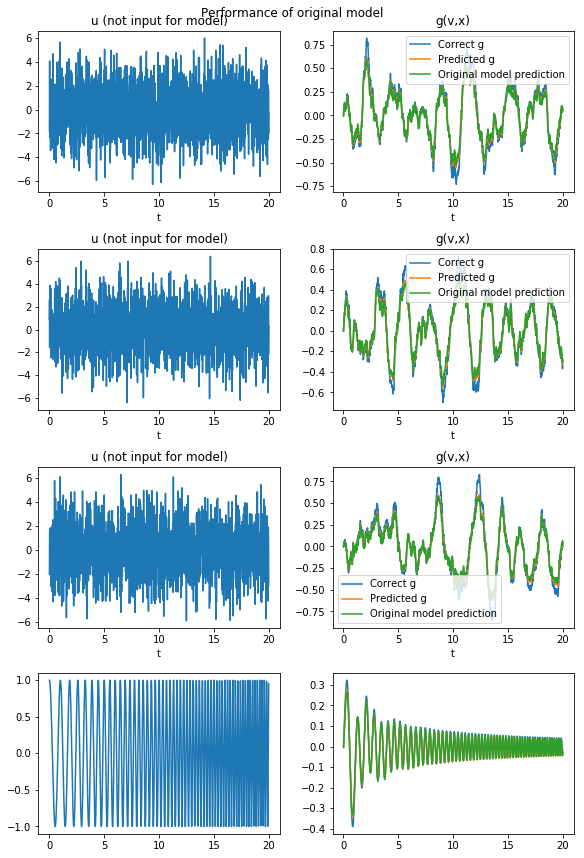

In [148]:
# Plot prediction 
plt.clf()
fig,axs = plt.subplots(Nseg, 2, constrained_layout=True, figsize = (8,12))
plot_skip_rate = 1 # Only plot a point for every this number of samples
for i in range(len(test_ind_list)-1):
    i0 = test_ind_list[i]
    i1 = test_ind_list[i+1]
    # Generate prediction
    result_alt = model_alt4.predict(input_f_test[i0:i1,1:3,:])
    # Plot both correct answer and prediction
    axs[i][0].plot(input_test[i][0,::plot_skip_rate], input_test[i][3,::plot_skip_rate])
    axs[i][0].set_title('u (not input for model)')
    axs[i][0].set_xlabel('t')
    axs[i][1].plot(input_test[i][0,frame_size:], np.squeeze(answer_f_test[i0:i1]))
    axs[i][1].plot(input_test[i][0,frame_size:], np.squeeze(result_alt))
    axs[i][1].plot(input_test[i][0,frame_size:], np.squeeze(model.predict(input_f_test[i0:i1,1:3,:])))
    axs[i][1].set_title('g(v,x)')
    axs[i][1].set_xlabel('t')
    axs[i][1].legend(['Correct g','Predicted g','Original model prediction'])
# fig.suptitle('Model trained with %d layers, each with %d neurons, taking %d recent samples' % (Nlayer, Nneuron, frame_size))
# Also show the performance on training data
axs[-1][0].plot(Inputset[0][0,::plot_skip_rate], Inputset[0][3,::plot_skip_rate])
axs[-1][1].plot(Inputset[0][0,:], Outputset[0][0])
axs[-1][1].plot(Inputset[0][0,frame_size:], model_alt4.predict(InputFset[:,1:3,:]))
axs[-1][1].plot(Inputset[0][0,frame_size:], model.predict(InputFset[:,1:3,:]))
fig.suptitle('Performance of original model')

Text(0.5, 0.98, 'Performance on sensical input (linear - quadratic)')

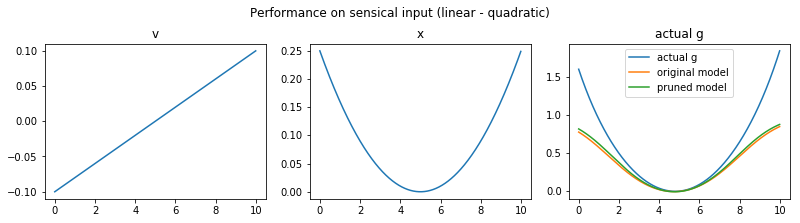

In [149]:
ttest = np.arange(0, 10, 0.01)
xtest = (ttest - 5) * (ttest - 5) / 100 # (t-5)^2/100
vtest = (ttest - 5) / 50                # (t-5)/50
gtest = 1.25*vtest + 2*np.pi*xtest + 10*xtest*xtest*xtest # 1.25v + 2pi*x + 10x^3
pred_test = model.predict(np.vstack((vtest, xtest)).T[:,:,None])
pruned_test = model_alt4.predict(np.vstack((vtest, xtest)).T[:,:,None])

figt,axst = plt.subplots(1, 3, constrained_layout=True, figsize = (11,3))
axst[0].plot(ttest, vtest)
axst[0].set_title('v')
axst[1].plot(ttest, xtest)
axst[1].set_title('x')
axst[2].plot(ttest, gtest)
axst[2].plot(ttest, pred_test)
axst[2].plot(ttest, pruned_test)
axst[2].set_title('actual g')
axst[2].legend(['actual g', 'original model','pruned model'])
figt.suptitle('Performance on sensical input (linear - quadratic)')

In [152]:
# Inspect weights
# print(model_alt.get_layer('dense_9').weights)
# print(model_alt.get_layer('dense_10').weights)
print(model_alt4.get_layer('dense_21').weights)
print(model_alt4.get_layer('dense_22').weights)
print(model_alt4.get_layer('dense_23').weights)
print(model_alt4.get_layer('dense_24').weights)
print(model_alt4.get_layer('dense_25').weights)
model_alt.summary()

[<tf.Variable 'dense_21/kernel:0' shape=(2, 2) dtype=float32, numpy=
array([[ 3.3406698e-04,  1.7333476e-01],
       [-2.8230570e-05,  7.5248319e-01]], dtype=float32)>, <tf.Variable 'dense_21/bias:0' shape=(2,) dtype=float32, numpy=array([0.00230043, 0.00295279], dtype=float32)>]
[<tf.Variable 'dense_22/kernel:0' shape=(2, 2) dtype=float32, numpy=
array([[-4.4253378e-05, -2.1419654e-04],
       [-1.2944068e-04,  9.2653602e-01]], dtype=float32)>, <tf.Variable 'dense_22/bias:0' shape=(2,) dtype=float32, numpy=array([0.0012238 , 0.00070631], dtype=float32)>]
[<tf.Variable 'dense_23/kernel:0' shape=(2, 2) dtype=float32, numpy=
array([[ 3.6597563e-04, -2.2177343e-04],
       [ 2.8117446e-04,  9.2180437e-01]], dtype=float32)>, <tf.Variable 'dense_23/bias:0' shape=(2,) dtype=float32, numpy=array([ 0.00140745, -0.00098682], dtype=float32)>]
[<tf.Variable 'dense_24/kernel:0' shape=(2, 2) dtype=float32, numpy=
array([[ 4.0180166e-05,  2.1205402e-04],
       [-2.6282715e-04, -9.1588485e-01]], dty

3. What if we take u as input as well?

3. 1. Include u in training input, and see what happens (position and velocity still stay)

In [154]:
tf.keras.backend.clear_session()

In [159]:
# Reconstruct neural nets
# Original: 2-(15,10)
model_o = tf.keras.models.Sequential([
#     tf.keras.layers.Flatten(),
    tf.keras.layers.Reshape((3,), input_shape=(3,1)), 
    tf.keras.layers.Dense(15, activation = Activation, kernel_regularizer = Regularizer, 
                          input_shape = (3,)),
    tf.keras.layers.Dense(10, activation = Activation, kernel_regularizer = Regularizer), 
    tf.keras.layers.Dense(1, activation = Activation)
])
Epoch = 200
model_o.compile(optimizer = 'adam', loss = tf.keras.losses.mean_squared_error)
model_o.fit(InputFset[:,1:,:], OutputFset, epochs=Epoch, callbacks=[tensorboard_callback])
model_o.summary()

# Reasonably pruned: 2-5
model_25 = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((3,), input_shape=(3,1)), 
    tf.keras.layers.Dense(5, activation = Activation, kernel_regularizer = Regularizer, 
                          input_shape = (3,)),
    tf.keras.layers.Dense(5, activation = Activation, kernel_regularizer = Regularizer), 
    tf.keras.layers.Dense(1, activation = Activation)
])
Epoch = 200
model_25.compile(optimizer = 'adam', loss = tf.keras.losses.mean_squared_error)
model_25.fit(InputFset[:,1:,:], OutputFset, epochs=Epoch, callbacks=[tensorboard_callback])
model_25.summary()

# Excessively pruned: 2-2
model_22 = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((3,), input_shape=(3,1)), 
    tf.keras.layers.Dense(2, activation = Activation, kernel_regularizer = Regularizer, 
                          input_shape = (3,)),
    tf.keras.layers.Dense(2, activation = Activation, kernel_regularizer = Regularizer), 
    tf.keras.layers.Dense(1, activation = Activation)
])
Epoch = 200
model_22.compile(optimizer = 'adam', loss = tf.keras.losses.mean_squared_error)
model_22.fit(InputFset[:,1:,:], OutputFset, epochs=Epoch, callbacks=[tensorboard_callback])
model_22.summary()

# Reasonably complicated: 4-2
model_4 = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((3,), input_shape=(3,1)), 
    tf.keras.layers.Dense(2, activation = Activation, kernel_regularizer = Regularizer, 
                          input_shape = (3,)),
    tf.keras.layers.Dense(2, activation = Activation, kernel_regularizer = Regularizer), 
    tf.keras.layers.Dense(2, activation = Activation, kernel_regularizer = Regularizer), 
    tf.keras.layers.Dense(2, activation = Activation, kernel_regularizer = Regularizer), 
    tf.keras.layers.Dense(1, activation = Activation)
])
Epoch = 200
model_4.compile(optimizer = 'adam', loss = tf.keras.losses.mean_squared_error)
model_4.fit(InputFset[:,1:,:], OutputFset, epochs=Epoch, callbacks=[tensorboard_callback])
model_4.summary()

# Since our Inputset etc. contains everything, we don't need to regenerate the data.

Train on 1999 samples
Epoch 1/200
1999/1999 [==============================] - 1s 257us/sample - loss: 0.0534
Epoch 2/200
1999/1999 [==============================] - 0s 41us/sample - loss: 0.0457
Epoch 3/200
1999/1999 [==============================] - 0s 40us/sample - loss: 0.0390
Epoch 4/200
1999/1999 [==============================] - 0s 42us/sample - loss: 0.0331
Epoch 5/200
1999/1999 [==============================] - 0s 40us/sample - loss: 0.0279
Epoch 6/200
1999/1999 [==============================] - 0s 42us/sample - loss: 0.0235
Epoch 7/200
1999/1999 [==============================] - 0s 39us/sample - loss: 0.0198
Epoch 8/200
1999/1999 [==============================] - 0s 39us/sample - loss: 0.0169
Epoch 9/200
1999/1999 [==============================] - 0s 36us/sample - loss: 0.0146
Epoch 10/200
1999/1999 [==============================] - 0s 39us/sample - loss: 0.0129
Epoch 11/200
1999/1999 [==============================] - 0s 38us/sample - loss: 0.0115
Epoch 12/200
1999/

Text(0.5, 0.98, 'Performance of original model')

<Figure size 432x288 with 0 Axes>

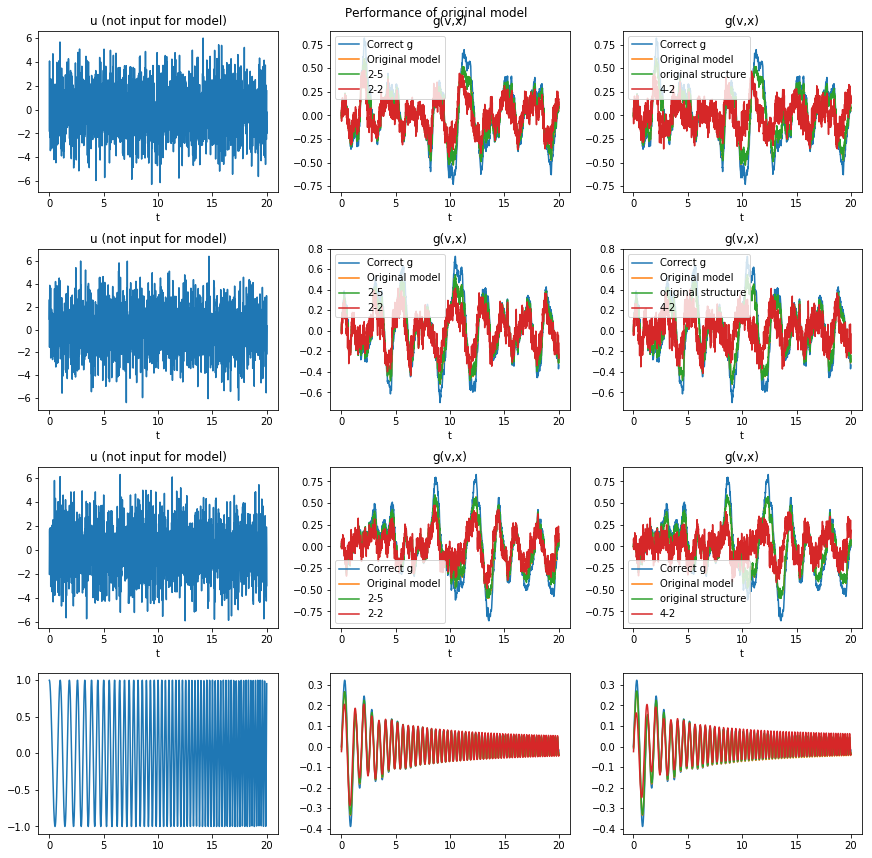

In [171]:
# Plot prediction 
plt.clf()
fig,axs = plt.subplots(Nseg, 3, constrained_layout=True, figsize = (12,12))
plot_skip_rate = 1 # Only plot a point for every this number of samples
for i in range(len(test_ind_list)-1):
    i0 = test_ind_list[i]
    i1 = test_ind_list[i+1]
    # Generate prediction
    # Plot both correct answer and prediction
    axs[i][0].plot(input_test[i][0,::plot_skip_rate], input_test[i][3,::plot_skip_rate])
    axs[i][0].set_title('u (not input for model)')
    axs[i][0].set_xlabel('t')
    axs[i][1].plot(input_test[i][0,frame_size:], np.squeeze(answer_f_test[i0:i1]))
#     axs[i][1].plot(input_test[i][0,frame_size:], np.squeeze(model_o.predict(input_f_test[i0:i1,1:,:])))
    axs[i][1].plot(input_test[i][0,frame_size:], np.squeeze(model.predict(input_f_test[i0:i1,1:3,:])))
    axs[i][1].plot(input_test[i][0,frame_size:], np.squeeze(model_25.predict(input_f_test[i0:i1,1:,:])))
    axs[i][1].plot(input_test[i][0,frame_size:], np.squeeze(model_22.predict(input_f_test[i0:i1,1:,:])))
#     axs[i][1].plot(input_test[i][0,frame_size:], np.squeeze(model_4.predict(input_f_test[i0:i1,1:,:])))
    axs[i][1].set_title('g(v,x)')
    axs[i][1].set_xlabel('t')
    axs[i][1].legend(['Correct g','Original model','2-5','2-2'])
    axs[i][2].plot(input_test[i][0,frame_size:], np.squeeze(answer_f_test[i0:i1]))
    axs[i][2].plot(input_test[i][0,frame_size:], np.squeeze(model.predict(input_f_test[i0:i1,1:3,:])))
    axs[i][2].plot(input_test[i][0,frame_size:], np.squeeze(model_o.predict(input_f_test[i0:i1,1:,:])))
#     axs[i][1].plot(input_test[i][0,frame_size:], np.squeeze(model_25.predict(input_f_test[i0:i1,1:,:])))
#     axs[i][1].plot(input_test[i][0,frame_size:], np.squeeze(model_22.predict(input_f_test[i0:i1,1:,:])))
    axs[i][2].plot(input_test[i][0,frame_size:], np.squeeze(model_4.predict(input_f_test[i0:i1,1:,:])))
    axs[i][2].set_title('g(v,x)')
    axs[i][2].set_xlabel('t')
    axs[i][2].legend(['Correct g','Original model','original structure','4-2'])
# Also show the performance on training data
axs[-1][0].plot(Inputset[0][0,::plot_skip_rate], Inputset[0][3,::plot_skip_rate])
axs[-1][1].plot(Inputset[0][0,:], Outputset[0][0])
axs[-1][1].plot(Inputset[0][0,frame_size:], model.predict(InputFset[:,1:3,:]))
axs[-1][1].plot(Inputset[0][0,frame_size:], model_25.predict(InputFset[:,1:,:]))
axs[-1][1].plot(Inputset[0][0,frame_size:], model_22.predict(InputFset[:,1:,:]))
axs[-1][2].plot(Inputset[0][0,:], Outputset[0][0])
axs[-1][2].plot(Inputset[0][0,frame_size:], model.predict(InputFset[:,1:3,:]))
axs[-1][2].plot(Inputset[0][0,frame_size:], model_o.predict(InputFset[:,1:,:]))
axs[-1][2].plot(Inputset[0][0,frame_size:], model_4.predict(InputFset[:,1:,:]))
fig.suptitle('Performances')

In [ ]:
# Inspect their weights. Note that layer names would change based on your runs.
print(model_o.get_layer('dense_3').weights)
print(model_25.get_layer('dense_6').weights)
print(model_22.get_layer('dense_9').weights)
print(model_4.get_layer('dense_17').weights)

3. 2. Now what happens if we remove the velocity / position? 
Removing position first, and see if they can figure out the dynamics. 

In [174]:
tf.keras.backend.clear_session()

In [175]:
# Original: 2-(15,10)
model_o = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((2,), input_shape=(2,1)), 
    tf.keras.layers.Dense(15, activation = Activation, kernel_regularizer = Regularizer, 
                          input_shape = (2,)),
    tf.keras.layers.Dense(10, activation = Activation, kernel_regularizer = Regularizer), 
    tf.keras.layers.Dense(1, activation = Activation)
])
Epoch = 200
model_o.compile(optimizer = 'adam', loss = tf.keras.losses.mean_squared_error)
model_o.fit(InputFset[:,[1,3],:], OutputFset, epochs=Epoch, callbacks=[tensorboard_callback])
model_o.summary()

# Reasonably pruned: 2-5
model_25 = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((2,), input_shape=(2,1)), 
    tf.keras.layers.Dense(5, activation = Activation, kernel_regularizer = Regularizer, 
                          input_shape = (2,)),
    tf.keras.layers.Dense(5, activation = Activation, kernel_regularizer = Regularizer), 
    tf.keras.layers.Dense(1, activation = Activation)
])
Epoch = 200
model_25.compile(optimizer = 'adam', loss = tf.keras.losses.mean_squared_error)
model_25.fit(InputFset[:,[1,3],:], OutputFset, epochs=Epoch, callbacks=[tensorboard_callback])
model_25.summary()

# Excessively pruned: 2-2
model_22 = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((2,), input_shape=(2,1)), 
    tf.keras.layers.Dense(2, activation = Activation, kernel_regularizer = Regularizer, 
                          input_shape = (2,)),
    tf.keras.layers.Dense(2, activation = Activation, kernel_regularizer = Regularizer), 
    tf.keras.layers.Dense(1, activation = Activation)
])
Epoch = 200
model_22.compile(optimizer = 'adam', loss = tf.keras.losses.mean_squared_error)
model_22.fit(InputFset[:,[1,3],:], OutputFset, epochs=Epoch, callbacks=[tensorboard_callback])
model_22.summary()

# Reasonably complicated: 4-2
model_4 = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((2,), input_shape=(2,1)), 
    tf.keras.layers.Dense(2, activation = Activation, kernel_regularizer = Regularizer, 
                          input_shape = (2,)),
    tf.keras.layers.Dense(2, activation = Activation, kernel_regularizer = Regularizer), 
    tf.keras.layers.Dense(2, activation = Activation, kernel_regularizer = Regularizer), 
    tf.keras.layers.Dense(2, activation = Activation, kernel_regularizer = Regularizer), 
    tf.keras.layers.Dense(1, activation = Activation)
])
Epoch = 200
model_4.compile(optimizer = 'adam', loss = tf.keras.losses.mean_squared_error)
model_4.fit(InputFset[:,[1,3],:], OutputFset, epochs=Epoch, callbacks=[tensorboard_callback])
model_4.summary()

Train on 1999 samples
Epoch 1/200
1999/1999 [==============================] - 1s 256us/sample - loss: 0.0512
Epoch 2/200
1999/1999 [==============================] - 0s 41us/sample - loss: 0.0446
Epoch 3/200
1999/1999 [==============================] - 0s 40us/sample - loss: 0.0393
Epoch 4/200
1999/1999 [==============================] - 0s 39us/sample - loss: 0.0344
Epoch 5/200
1999/1999 [==============================] - 0s 39us/sample - loss: 0.0299
Epoch 6/200
1999/1999 [==============================] - 0s 39us/sample - loss: 0.0260
Epoch 7/200
1999/1999 [==============================] - 0s 38us/sample - loss: 0.0228
Epoch 8/200
1999/1999 [==============================] - 0s 39us/sample - loss: 0.0201
Epoch 9/200
1999/1999 [==============================] - 0s 40us/sample - loss: 0.0177
Epoch 10/200
1999/1999 [==============================] - 0s 39us/sample - loss: 0.0155
Epoch 11/200
1999/1999 [==============================] - 0s 39us/sample - loss: 0.0138
Epoch 12/200
1999/

Text(0.5, 0.98, 'Performances without position input')

<Figure size 432x288 with 0 Axes>

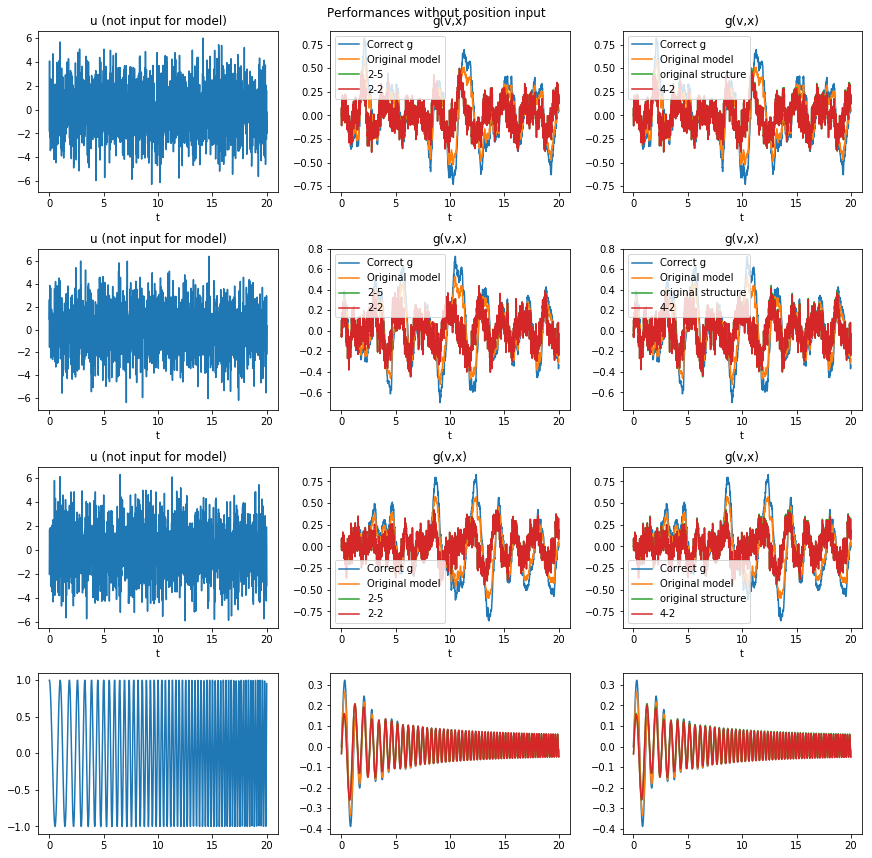

In [176]:
# Plot prediction 
plt.clf()
fig,axs = plt.subplots(Nseg, 3, constrained_layout=True, figsize = (12,12))
plot_skip_rate = 1 # Only plot a point for every this number of samples
for i in range(len(test_ind_list)-1):
    i0 = test_ind_list[i]
    i1 = test_ind_list[i+1]
    # Generate prediction
    # Plot both correct answer and prediction
    axs[i][0].plot(input_test[i][0,::plot_skip_rate], input_test[i][3,::plot_skip_rate])
    axs[i][0].set_title('u (not input for model)')
    axs[i][0].set_xlabel('t')
    axs[i][1].plot(input_test[i][0,frame_size:], np.squeeze(answer_f_test[i0:i1]))
#     axs[i][1].plot(input_test[i][0,frame_size:], np.squeeze(model_o.predict(input_f_test[i0:i1,1:,:])))
    axs[i][1].plot(input_test[i][0,frame_size:], np.squeeze(model.predict(input_f_test[i0:i1,1:3,:])))
    axs[i][1].plot(input_test[i][0,frame_size:], np.squeeze(model_25.predict(input_f_test[i0:i1,[1,3],:])))
    axs[i][1].plot(input_test[i][0,frame_size:], np.squeeze(model_22.predict(input_f_test[i0:i1,[1,3],:])))
#     axs[i][1].plot(input_test[i][0,frame_size:], np.squeeze(model_4.predict(input_f_test[i0:i1,1:,:])))
    axs[i][1].set_title('g(v,x)')
    axs[i][1].set_xlabel('t')
    axs[i][1].legend(['Correct g','Original model','2-5','2-2'])
    axs[i][2].plot(input_test[i][0,frame_size:], np.squeeze(answer_f_test[i0:i1]))
    axs[i][2].plot(input_test[i][0,frame_size:], np.squeeze(model.predict(input_f_test[i0:i1,1:3,:])))
    axs[i][2].plot(input_test[i][0,frame_size:], np.squeeze(model_o.predict(input_f_test[i0:i1,[1,3],:])))
#     axs[i][1].plot(input_test[i][0,frame_size:], np.squeeze(model_25.predict(input_f_test[i0:i1,1:,:])))
#     axs[i][1].plot(input_test[i][0,frame_size:], np.squeeze(model_22.predict(input_f_test[i0:i1,1:,:])))
    axs[i][2].plot(input_test[i][0,frame_size:], np.squeeze(model_4.predict(input_f_test[i0:i1,[1,3],:])))
    axs[i][2].set_title('g(v,x)')
    axs[i][2].set_xlabel('t')
    axs[i][2].legend(['Correct g','Original model','original structure','4-2'])
# Also show the performance on training data
axs[-1][0].plot(Inputset[0][0,::plot_skip_rate], Inputset[0][3,::plot_skip_rate])
axs[-1][1].plot(Inputset[0][0,:], Outputset[0][0])
axs[-1][1].plot(Inputset[0][0,frame_size:], model.predict(InputFset[:,1:3,:]))
axs[-1][1].plot(Inputset[0][0,frame_size:], model_25.predict(InputFset[:,[1,3],:]))
axs[-1][1].plot(Inputset[0][0,frame_size:], model_22.predict(InputFset[:,[1,3],:]))
axs[-1][2].plot(Inputset[0][0,:], Outputset[0][0])
axs[-1][2].plot(Inputset[0][0,frame_size:], model.predict(InputFset[:,1:3,:]))
axs[-1][2].plot(Inputset[0][0,frame_size:], model_o.predict(InputFset[:,[1,3],:]))
axs[-1][2].plot(Inputset[0][0,frame_size:], model_4.predict(InputFset[:,[1,3],:]))
fig.suptitle('Performances without position input')

In [ ]:
# Weights
print(model_o.get_layer('dense').weights)
print(model_25.get_layer('dense_3').weights)
print(model_22.get_layer('dense_6').weights)
print(model_4.get_layer('dense_9').weights)